In [6]:
# Install NLTK for tokenization algorithms

!pip install nltk
!pip install matplotlib
!pip install -U scikit-learn
!pip install -U numpy
!pip install -U scipy


[notice] A new release of pip available: 22.3 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [130]:
# Import necessary libraries for corpora training and for using NLTK library.

from collections import defaultdict
import matplotlib.pyplot as plt
import random
import nltk
from nltk.corpus import gutenberg, movie_reviews, stopwords
from nltk.tokenize import PunktSentenceTokenizer, word_tokenize
from nltk.stem import WordNetLemmatizer
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import numpy as np

nltk.download('gutenberg')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('movie_reviews')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

[nltk_data] Downloading package gutenberg to C:\Users\Agasti
[nltk_data]     Mhatre\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Agasti
[nltk_data]     Mhatre\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to C:\Users\Agasti
[nltk_data]     Mhatre\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package movie_reviews to C:\Users\Agasti
[nltk_data]     Mhatre\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Agasti
[nltk_data]     Mhatre\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Agasti
[nltk_data]     Mhatre\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [9]:
# Put each token in a linked list node. This way, when merges happen,
# the node after it can be removed in O(1) time and the new merged token
# can happen in the current node.
class ListNode:

    def __init__(self, val):

        self.val = val
        self.next = None

## Common functions used in both training and testing functions for BPE

# Convert current string into a linked list format
def string_to_linked_list(curr_string):

    # Head of the linked List
    l_string = curr = None
    c = 0

    # Skip over any leading whitespace in the string
    while c < len(curr_string):

        if curr_string[c] not in [' ', '\n', '\t']: break
        c += 1
        
    # Turn string in a linked list where each node
    # is either a letter or an underscore (remove whitespace)
    while c < len(curr_string): 
    
        # If the current letter in the string is a whitespace, turn
        # it into an underscore and put it in the linked list
        # Otherwise, continue on in the string and add each
        # letter to a linked list node
        addUnderScore = False
        while c < len(curr_string):
            
            if curr_string[c] not in [' ', '\n', '\t']: break
            else: addUnderScore = True
            
            c += 1

        if addUnderScore:

            curr.next = ListNode('_')
            curr = curr.next

        if c >= len(curr_string): break

        # Set the head of the l_string linked list
        # if it is not currently set.
        # Otherwise, add another child node to the
        # linked list
        if l_string == None: 
            
            l_string = ListNode(curr_string[c])
            curr = l_string

        else:

            curr.next = ListNode(curr_string[c])
            curr = curr.next

        c += 1

    return l_string

# Combine two tokens into one by
# removing y's node and merging it
# into x's node
def merge_rules(l_string, x, y): 
        
    temp = x + y
    curr = l_string
    while curr != None:

        if curr.next == None: break
        if (x == curr.val) and (y == curr.next.val):

            curr.next = curr.next.next
            curr.val = temp

        curr = curr.next

# Extract the current vocabulary
# by traversing the entire linked
# list and return it so it could
# be added to the larger vocabulary
def extract_vocabulary(l_string):

    # Each list node is a token
    # that can now be part of the
    # vocabulary
    temp = set()
    curr = l_string
    while curr != None:

        temp.add(curr.val)
        curr = curr.next

    # Remove underscores from each token
    vocabulary = set()
    for token in temp:

        i = 0
        j = len(token)
        if token[i] == '_': i += 1
        if token[j - 1] == '_': j -= 1

        words = token[i:j].split("_")

        for word in words: vocabulary.add(word)

    return vocabulary
    

In [137]:
### 1. Implement BPE Algorithm

# Find rules to merge tokens. Take a test string
# and run BPE algorithm on it (for k iterations) 
# to find the rules and generate the vocabulary.
def trainBPE(train_string, k):

    rules = []
    vocabulary = set()

    vocab_size_evol = []
    freq_BPE = []

    l_string = string_to_linked_list(train_string)
    
    # Run the BPE algorithm for k iterations
    for i in range(k):

        # Add current vocabulary to complete vocabulary
        # set
        vocabulary.update(extract_vocabulary(l_string))

        # Track current vocabulary size
        vocab_size_evol.append(len(vocabulary))

        # Store the frequency of the current iteration's
        # most common pairs that occur together
        freq_ = defaultdict(lambda: 0)
        curr = l_string
        while curr.next != None: 

            freq_[(curr.val, curr.next.val)] += 1
            curr = curr.next

        # Find the pair of tokens which occurs 
        # together the most frequently
        max_rule = None
        max_num = 0
        for rule, num in freq_.items():

            if num > max_num:

                max_rule = rule
                max_num = num

        # If there is no rule that is found, stop the
        # algorithm
        if max_rule == None: break

        # Go through the string and merge the most frequent 
        # pair according to the rule found
        x, y = max_rule
        rules.append((x, y))

        # Store most frequent rule for each kth iteration
        freq_BPE.append((x, y, max_num))

        merge_rules(l_string, x, y)

    vocabulary.update(extract_vocabulary(l_string))
    vocab_size_evol.append(len(vocabulary))
    
    return vocabulary, rules, vocab_size_evol, freq_BPE, l_string

# Test on the following string for k=17 iterations
#vocabulary, rules, vocab_size_evol, freq_BPE, l_string = trainBPE("low low low lowest lowest newer newer wider wider new new", 17)

#print("Vocabulary: ", vocabulary)
#print("Rules: ", rules)

In [11]:
# Use merging rules in order to generate tokens from testing corpus
def testBPE(test_string, rules):

    l_string = string_to_linked_list(test_string)
    vocabulary = set()

    for rule in rules:

        vocabulary.update(extract_vocabulary(l_string))
        x, y = rule
        merge_rules(l_string, x, y)

    vocabulary.update(extract_vocabulary(l_string))
    return extract_vocabulary(l_string)


In [159]:
# Given a string, encode it via BPE
def encode(encode_string):

    tempVocab, encodingRules, tempVocabSize, tempFreq_BPE, l_string = trainBPE(encode_string, 7)

    return encodingRules, l_string

# Example with "Hello world" string
encodingRules, l_string = encode("Hello world")
encoded_string = []
# Iterate through linked list and append individual tokens to the
# list. Each value at each index represents a token that has now
# been encoded.
curr = l_string
while curr != None: 
        
    encoded_string.append(curr.val)
    curr = curr.next

print("Encoded string: ", encoded_string)
print("Encoding rules: ", encodingRules)

Encoded string:  ['Hello_wo', 'r', 'l', 'd']
Encoding rules:  [('H', 'e'), ('He', 'l'), ('Hel', 'l'), ('Hell', 'o'), ('Hello', '_'), ('Hello_', 'w'), ('Hello_w', 'o')]


In [162]:
# Use the rules to in reverse order
# to decode the string. This should
# yield the decoded string.
def decode(decode_string, rules):

    # Traverse through the rules in reverse order
    # to complete the merge
    rulesBackwords = rules[::-1]

    # Instantiate new linked list
    l_string = None
    if len(decode_string) > 0: l_string = ListNode(decode_string[0])

    # Convert string into linked list
    curr = l_string
    for tok in decode_string[1:]:

        curr.next = ListNode(tok)
        curr = curr.next

    # Keep merging the string from the rules
    for currRule in rulesBackwords:

        x, y = currRule
        curr = l_string
        while curr != None: 
        
            if (curr.val == (x + y)):

                print(curr.val, x, y)
                temp = ListNode(y)
                curr.val = x
                temp.next = curr.next
                curr.next = temp

            curr = curr.next

    return l_string

# Decode the string from the earlier "Hello world"
# example.
l_string = decode(encoded_string, encodingRules)

decoded_string = []
curr = l_string
temp = []
while curr != None:

    if (curr.val == '_'): 
        
        decoded_string.append("".join(temp) + " ")
        temp = []

    else: temp.append(curr.val)

    curr = curr.next

decoded_string.append("".join(temp) + " ")

decoded_string = "".join(decoded_string)
print(decoded_string)


Hello_wo Hello_w o
Hello_w Hello_ w
Hello_ Hello _
Hello Hell o
Hell Hel l
Hel He l
He H e
Hello world 


In [ ]:
### 2. Train on NLTK Dataset

# Store the training text
text = gutenberg.raw('austen-emma.txt')

vocabulary, rules, vocab_size_evol, freq_BPE, l_string = trainBPE(text, 1000)

print("Vocabulary: ", vocabulary)
print("Rules: ", rules)
print("Vocabulary Size Evolution: ", vocab_size_evol)
print("Byte Pair Merge Frequencies: ", freq_BPE)

Vocabulary:  {'', 'pla', 'are', 'mom', 'imagin', 'comfort', 'mi', 'very', 'equ', 'consid', 'odd', 'hile', 'carriag', 'Wes', 'har', 'arm', 'pri', 'pass', 'pleas', 'anc', 'or', 'op', 'beli', 'under', 'j', '`', 'ev', 'dear', 'delight', 'mith', 've', 'ak', 'your', 'ide', 'si', 'as', 'ld', 'good', 'ction', 'V', 'might', 'lig', 'half', 'Highbur', 'soon', 'fel', 'beg', '--and', 'eth', 'f', 'cons', 'immedi', 'tak', ')', 'befor', 'ort', 'done', 'fer', 'fri', 'Churchi', 'pe', 'Fair', 'pl', 'engag', 'heard', 'peri', 'press', 'Knightle', 'ity', 'go', 're', 'The', 'dire', 'medi', 'never', 'igh', 'and', 'night', 'ally', 'ver', 'cir', 'res', 'ma', 'room', 'un', 'ought', 'inc', 'erv', 'loo', 'gener', 'ed,', 'believ', 'were', 'pro', 'bl', 'his', 'id', 'ton', 'from', 'la', 'e--', 'ght', 'gr', 'if', 'Elton', 'oblig', 'alway', 'Frank', 'ard', 'ey', 'med', 'ound', 'visit', 'q', 'rat', 'hal', 'giv', 'int', 'je', 'always', 'particul', "'", 'ful', 'wa', 'Martin', 's,', '6', 'oft', 'dec', '--but', 'much', 'fir

In [13]:
# Download Frankenstein .txt file from https://www.gutenberg.org/cache/epub/84/pg84.txt
with open("frankenstein.txt", "r", encoding="utf-8") as file:
    frankenstein = file.read()

In [14]:
### 3. Test on NLTK Dataset
vocabulary = testBPE(frankenstein, rules)
print(vocabulary)

{'pla', '', 'are', 'L', 'em', 'mom', 'without', 'imagin', 'comfort', 'you', 'own', 'mi', 'y,', 'very', 'equ', 'consid', '4', '/', 'hile', 'ea', 'carriag', 'Wes', 'letter', 'ond', 'their', 'har', 'yself', 'wo', 'd', 'ter', 'is', 'N', 'e.', 'der', 'U', 'noth', 'ol', 'vour', 'arm', 'ad', 'pri', 'pass', 'ob', 'pleas', 'anc', 'or', 'op', 'am', 'beli', 'under', 'j', 'You', 'ev', 'dear', 'delight', 've', 'ak', 'um', 'é', '”', 'your', 'ement', 'ide', 'si', 'may', 'thought', 'quite', 'little', '“', 'did', 'es,', 'as', '—', 'chan', 'ld', 'ru', 'good', 'ction', 'see', 'V', 'li', 'lig', 'might', 'z', 'half', 'uch', 'soon', 'what', 'fel', 'de', 'ish', 'wh', 'beg', 'tal', 'gin', 'du', 'er', 'hav', 'eth', 'nd', 'f', 'give', 'cons', 'bro', 'off', 'immedi', 'tak', 'year', 'quaint', 'dra', 'ng', ')', 'ort', 'befor', 'done', 'fer', 'po', 'fri', 'thin', 'pe', 'great', 'Fair', 'pl', 'engag', '3', 'heard', '’', 'it', 'peri', 'press', 'expect', 'take', 'ce', 'è', 'ity', 'go', 'The', 're', 'dire', 'her', 'ô',

In [20]:
### 4. Create Reference Tokenization

#punkt_tokenizer = PunktSentenceTokenizer()
#tokens = punkt_tokenizer.tokenize(frankenstein)
#for tok in tokens: 
    
#    print(tok)
#    print("____________________________________________________________")

tokens = word_tokenize(frankenstein)
for tok in tokens: 
    
    print(tok)
    print("____________________________________________________________")

The
____________________________________________________________
Project
____________________________________________________________
Gutenberg
____________________________________________________________
eBook
____________________________________________________________
of
____________________________________________________________
Frankenstein
____________________________________________________________
;
____________________________________________________________
Or
____________________________________________________________
,
____________________________________________________________
The
____________________________________________________________
Modern
____________________________________________________________
Prometheus
____________________________________________________________
This
____________________________________________________________
ebook
____________________________________________________________
is
___________________________________________________________

In [21]:
### 5. Compare with Standard Tokenization

# Accuracy
total_num_tokens = len(set(tokens))
num_correct_tokens = len(vocabulary.intersection(set(tokens)))
accuracy = (num_correct_tokens / total_num_tokens) * 100
print("Accuracy: ", accuracy)

# Coverage
num_unique_tokens = len(vocabulary)
total_num_unique_tokens_ground_truth = len(set(tokens))
coverage = (num_unique_tokens / total_num_unique_tokens_ground_truth) * 100
print("Coverage: ", coverage)

# Precision, Recall, F1-Score
true_positive = len(vocabulary.intersection(set(tokens)))
false_positive = len(vocabulary - set(tokens))
false_negative = len(set(tokens) - vocabulary)

print("True positive: ", true_positive)
print("False positive: ", false_positive)
print("False negative: ", false_negative)

precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)
f1_score = 2 * ((precision * recall) / (precision + recall))

print("Precision: ", precision)
print("Recall: ", recall)
print("F1-Score: ", f1_score)

# Jaccard Similarity
intersection_predicted_ground = len(vocabulary.intersection(set(tokens)))
union_predicted_ground = len(vocabulary.union(set(tokens)))
jaccard_similarity = intersection_predicted_ground / union_predicted_ground

print("Intersection of Predicted and Ground Truth Tokens: ", intersection_predicted_ground)
print("Union of Predicted and Ground Truth Tokens: ", union_predicted_ground)
print("Jaccard Similarity: ", jaccard_similarity)


Accuracy:  3.308012741975006
Coverage:  8.649840725312423
True positive:  270
False positive:  436
False negative:  7892
Precision:  0.38243626062322944
Recall:  0.03308012741975006
F1-Score:  0.06089309878213802
Intersection of Predicted and Ground Truth Tokens:  270
Union of Predicted and Ground Truth Tokens:  8598
Jaccard Similarity:  0.0314026517794836


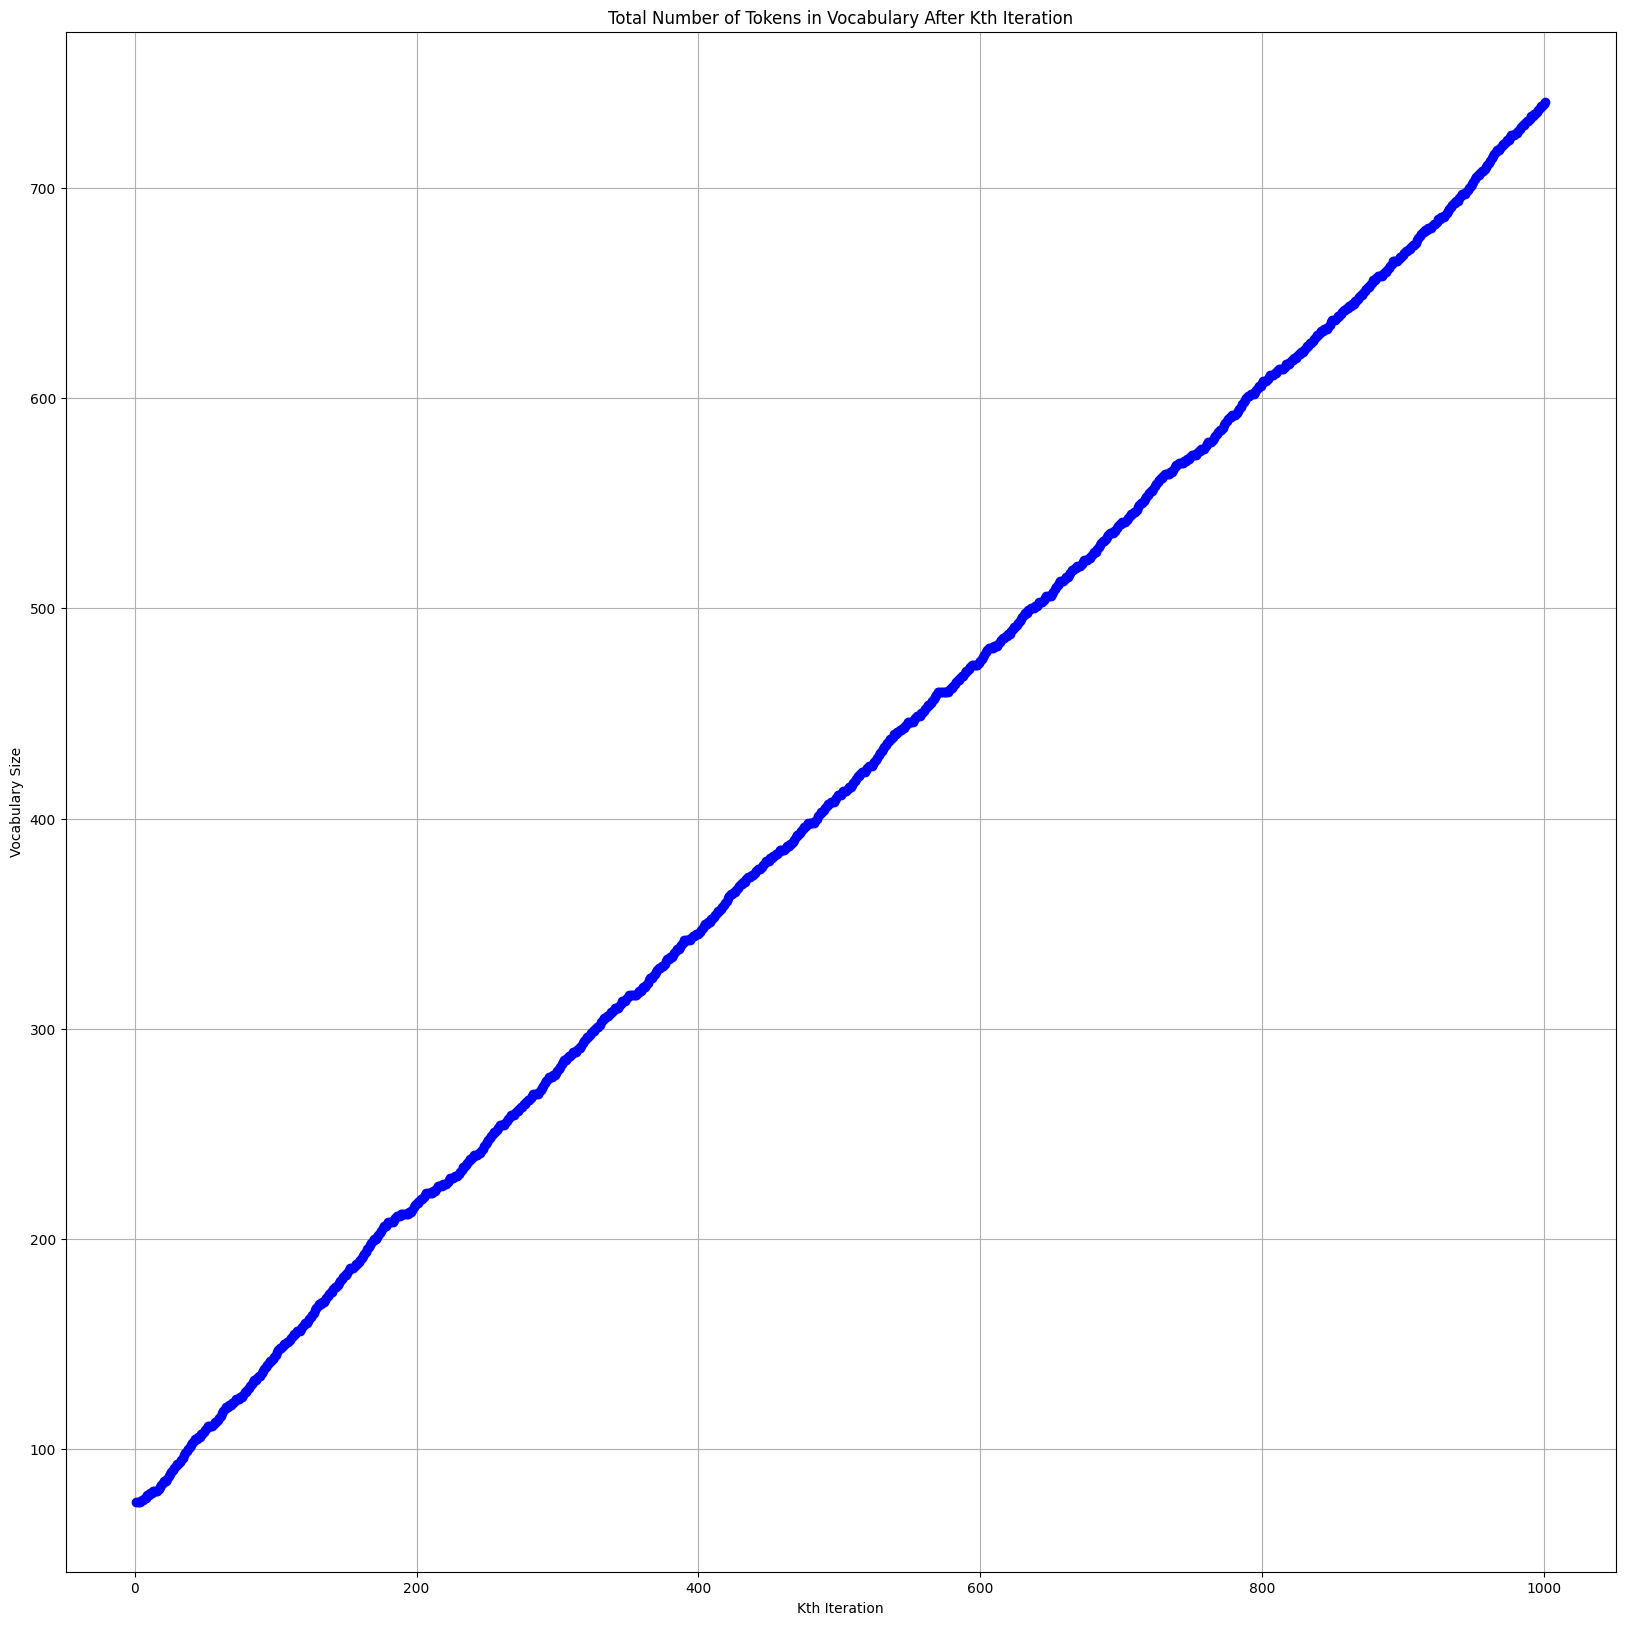

In [22]:
### 6. Visualizations - Vocabulary Size

kth_iter = range(1, len(vocab_size_evol) + 1)
plt.figure(figsize=(20, 20))
plt.plot(kth_iter, vocab_size_evol, marker='o', color='b')
plt.xlabel("Kth Iteration") 
plt.ylabel("Vocabulary Size")
plt.title("Total Number of Tokens in Vocabulary After Kth Iteration")
plt.grid(True)
plt.show()

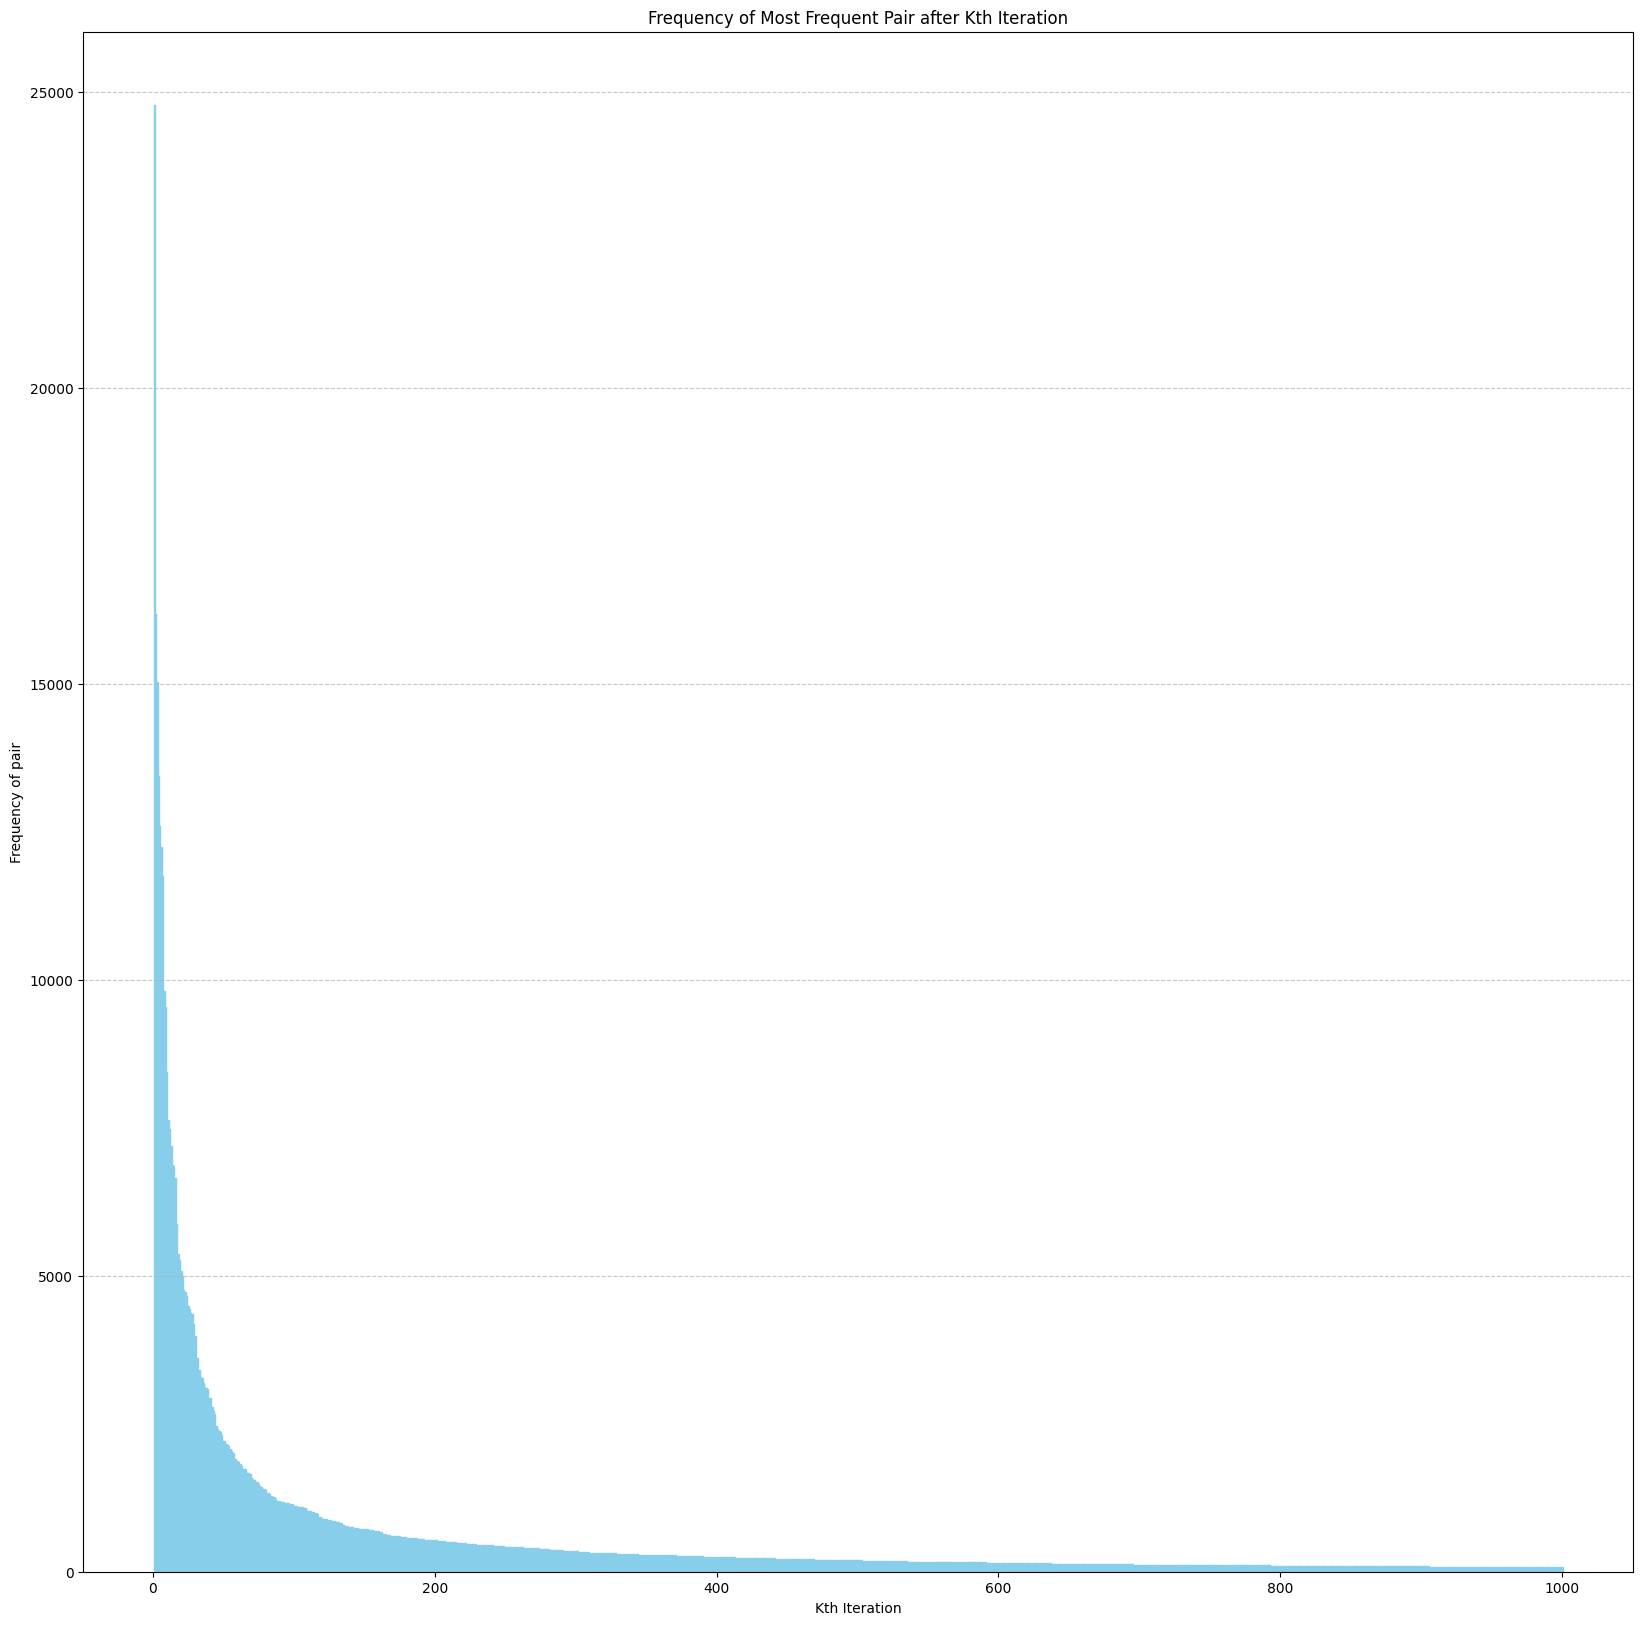

In [23]:
### 6. Visualizations - Byte Pair Frequency

y_values = [item[2] for item in freq_BPE] 

kth_iter = range(1, len(freq_BPE) + 1)

plt.figure(figsize=(20, 20))
plt.bar(kth_iter, y_values, color='skyblue', edgecolor='skyblue')
plt.xlabel("Kth Iteration")
plt.ylabel("Frequency of pair")
plt.title("Frequency of Most Frequent Pair after Kth Iteration")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

# Part 7 - Report and Discussion

# Second Half of Assignment 1

In [24]:
### 1. Data Preparation

# Access the movie reviews and labels
documents = [(list(movie_reviews.words(fileid)), category)
for category in movie_reviews.categories()
for fileid in movie_reviews.fileids(category)]
random.shuffle(documents)

print("Sample Review:", documents[0][0][:10])
print("Label:", documents[0][1])

Sample Review: ['synopsis', ':', 'leonard', 'shelby', '(', 'pearce', ')', 'is', 'a', 'former']
Label: pos


In [25]:
def find_coverage_after_processing(num_documents):

    stop_words = set(stopwords.words('english'))

    # Remove stop words from all document word lists
    all_words = set()
    filtered_words = set()
    for document in documents[:num_documents]:

        all_words.update({word.lower() for word in document[0]})
        filtered_words.update({word.lower() for word in document[0] if word.lower() not in stop_words})

    lemmatizer = WordNetLemmatizer()

    # Lemmatize all of the remaining words
    # in the filtered word set
    lemmas = set()
    for word in filtered_words:

        try: lemmas.add(lemmatizer.lemmatize(word))
        except Exception as e: print(e)

    return lemmas, all_words


In [26]:
step = 1
num_all = []
coverage_percentage = []
for i in range(step, 700, step):

    processed_words, all_words = find_coverage_after_processing(i)
    num_all.append(len(all_words))
    coverage_percentage.append(len(processed_words) / len(all_words))

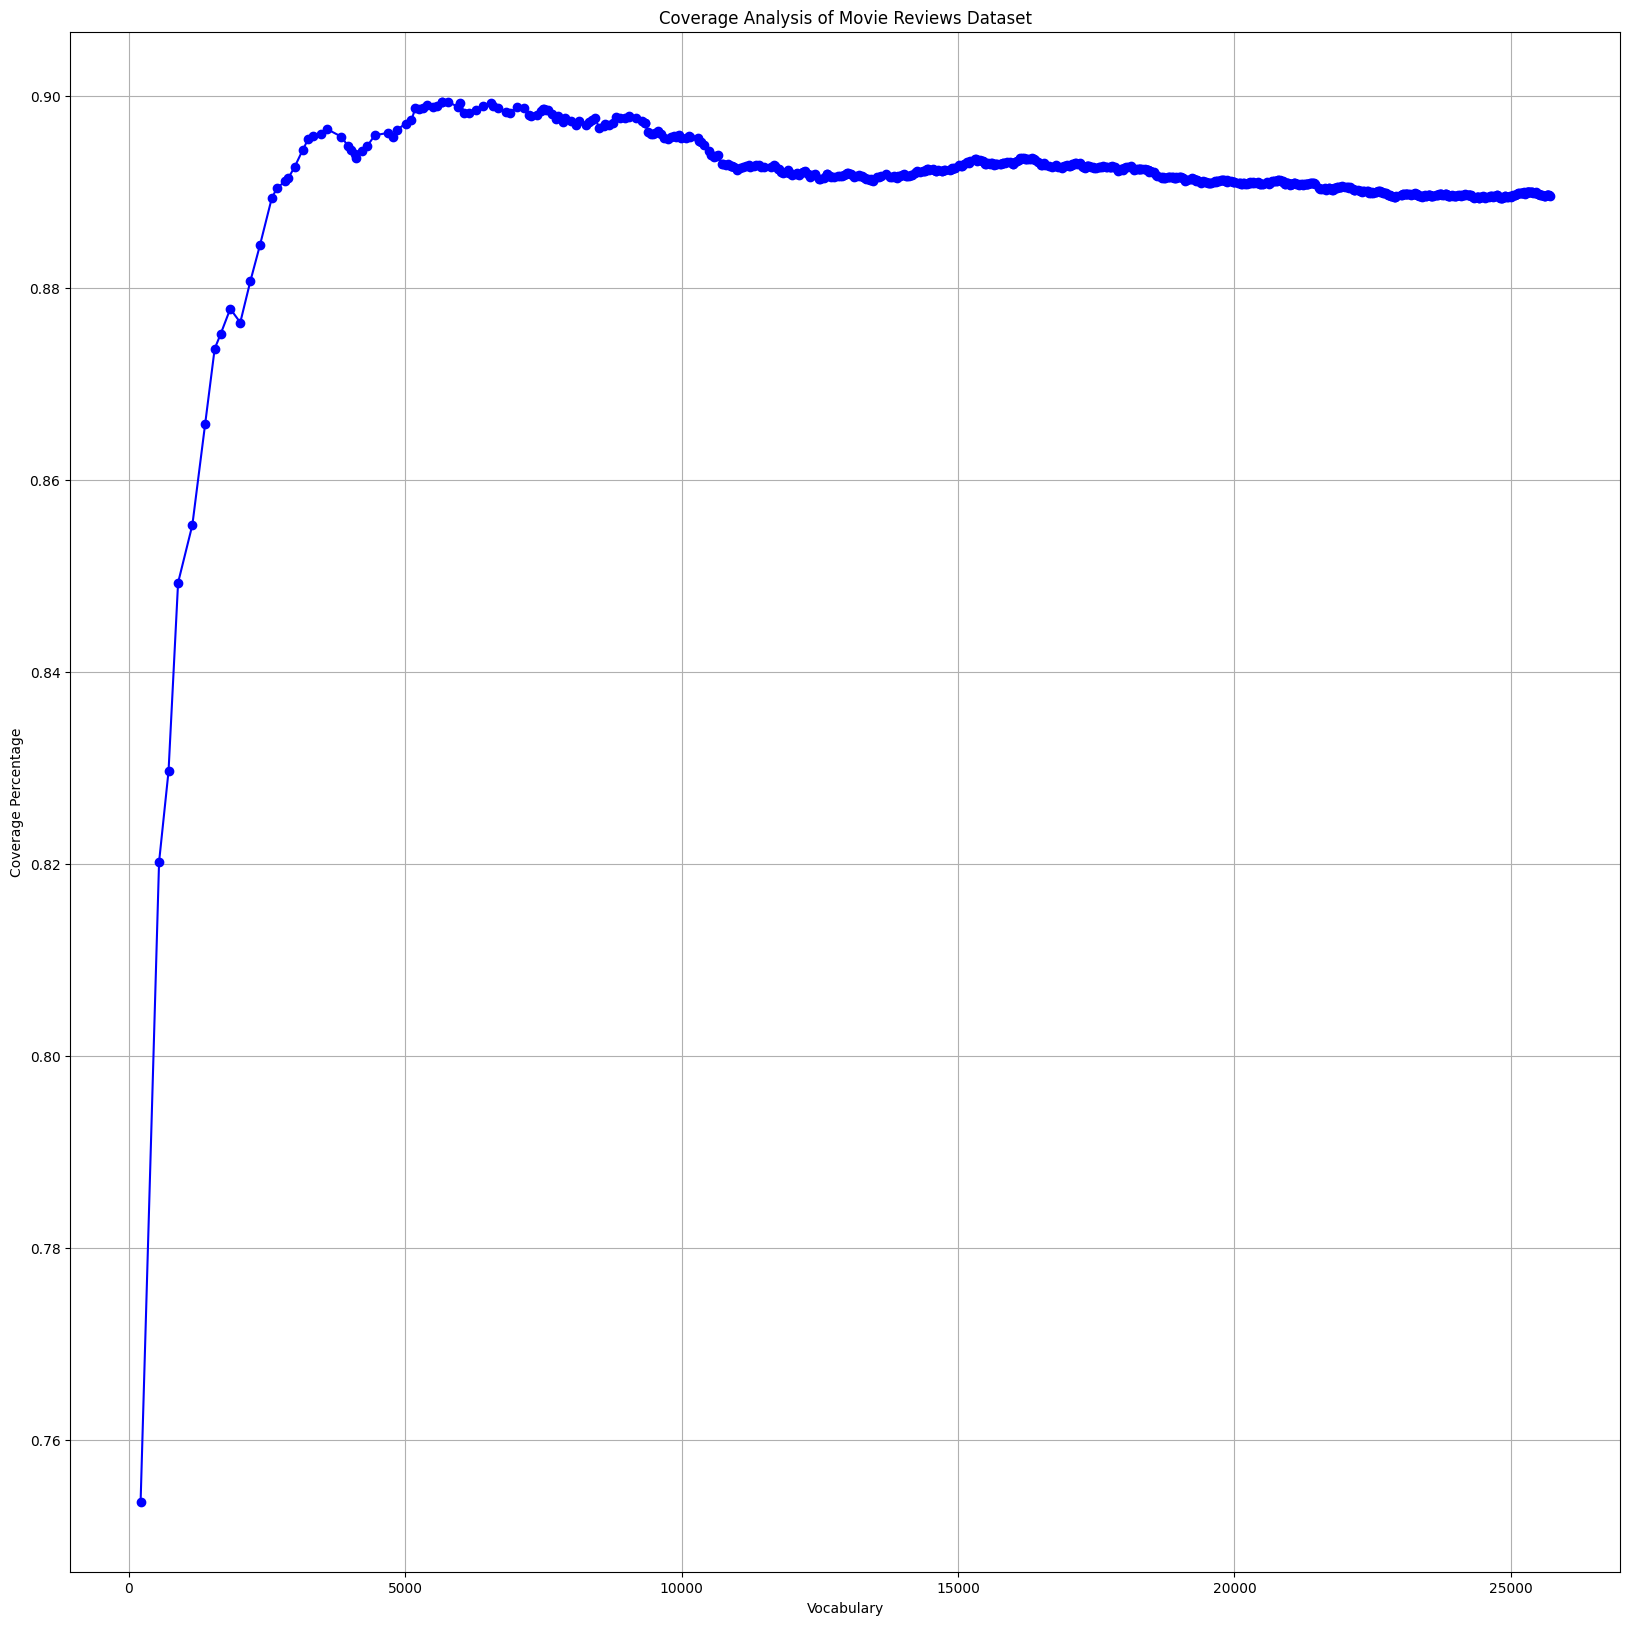

In [27]:
plt.figure(figsize=(20, 20))
plt.plot(num_all, coverage_percentage, marker='o', color='b')
plt.xlabel("Vocabulary") 
plt.ylabel("Coverage Percentage")
plt.title("Coverage Analysis of Movie Reviews Dataset")
plt.grid(True)
plt.show()

##### How does the coverage change with the number of tokens considered?
The coverage exponentially increases between ~500 to ~2,500 tokens considered. This is because as we start our tokenization process, we are exposed to many new words that aren't in our vocabulary yet. As we continue exploring words, however, we start to come across repeated words which may be in different forms. When we lemmatize, however, this brings down the number of new words that we see down, and we end up with a lot of repeated vocabulary.

##### At what point does the coverage seem to stabilize?
The coverage seems to stabilize at around 5,000 words. After this point, it seems to converge to a coverage of about 0.89.

##### Are there diminishing returns in terms of coverage as the number of tokens increases?
There are diminishing returns as the number of tokens increases. Firstly, the coverage seems to slowly decrease after about 10,000 vocabulary words considered. Secondly, it takes increasingly longer to compute more vocabulary words which is not necessary if it hits its peak at 5,000 words.

##### Rationale for Vocabulary Choice
When choosing a very large vocabulary size, some of the pros include feeding your model a big enough corpus such that it can detect more rare words which may be beneficial in instances where those rare words may be very significant. Doing this, however, would decrease the model's ability to generalize because it can overfit the training data if it is given too many rare words. Likewise, the model complexity will increase given more features which may increase its informativeness, but it will cause more processing time for the algorithm. In terms of algorithm choice, naive bayes handles smaller vocabularies better than larger ones because it assigns weights to all of the words, and it assumes independence between all of the words in the vocabulary. A large vocabulary may make Naive Bayes overfit because it may assign weights that are too heavy for rarer words. Logistic Regression may be better for medium-sized vocabularies, but it may overfit for noisy data or irrelevant words. Finally, the multi-layer perceptron may be the best for large vocabulary sizes since it has multiple layers that can capture the complex relationships between words in the vocabulary, but it may take the longest since it requires much data and builds these complex relationships.

In [61]:
stop_words = set(stopwords.words('english'))
def process(document):

    lemmatizer = WordNetLemmatizer()

    lemmas = []
    for word in document:

        if word.lower() in stop_words: continue
        try: lemmas.append(lemmatizer.lemmatize(word.lower()))
        except Exception as e: print(e)

    return lemmas

In [62]:
review = []
sentiment = []

for document in documents:

    review.append(process(document[0]))
    sentiment.append(1 if document[1] == "pos" else 0)

In [112]:
x_train, x_test, y_train, y_test = train_test_split(review, sentiment, test_size=0.2, random_state=50)
y_test = np.array(y_test)

In [113]:
x_train_string = [" ".join(tokens) for tokens in x_train]
x_test_string = [" ".join(tokens) for tokens in x_test]

In [114]:
tf_vectorizer = CountVectorizer()

x_train_tf = tf_vectorizer.fit_transform(x_train_string)
x_test_tf = tf_vectorizer.transform(x_test_string)

In [115]:
tfidf_vectorizer = TfidfVectorizer()

x_train_tfidf = tfidf_vectorizer.fit_transform(x_train_string)
x_test_tfidf = tfidf_vectorizer.transform(x_test_string)

In [116]:
def find_metrics(y_pred, y_test):

    TP = np.sum((y_pred == 1) & (y_test == 1))
    TN = np.sum((y_pred == 0) & (y_test == 0))
    FP = np.sum((y_pred == 1) & (y_test == 0))
    FN = np.sum((y_pred == 0) & (y_test == 1))

    return int(TP), int(TN), int(FP), int(FN)



In [120]:
# Multinomial Naive Bayes - TF

model = MultinomialNB()
model.fit(x_train_tf, y_train)
y_pred = model.predict(x_test_tf)

print(find_metrics(y_pred, y_test))

(174, 155, 36, 35)


In [121]:
# Multinomial Naive Bayes - TFIDF

model = MultinomialNB()
model.fit(x_train_tfidf, y_train)
y_pred = model.predict(x_test_tfidf)

print(find_metrics(y_pred, y_test))


(165, 160, 31, 44)


In [126]:
# Logistic Regression - TF

model = LogisticRegression(max_iter=5000, random_state=50)
model.fit(x_train_tf, y_train)
y_pred = model.predict(x_test_tf)

print(find_metrics(y_pred, y_test))

(173, 162, 29, 36)


In [ ]:
# Logistic Regression - TFIDF

model = LogisticRegression(max_iter=5000, random_state=50)
model.fit(x_train_tfidf, y_train)
y_pred = model.predict(x_test_tfidf)

print(find_metrics(y_pred, y_test))

(176, 153, 38, 33)


In [133]:
model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=50)
model.fit(x_train_tf, y_train)
y_pred = model.predict(x_test_tf)

print(find_metrics(y_pred, y_test))

(177, 161, 30, 32)


In [134]:
model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=50)
model.fit(x_train_tfidf, y_train)
y_pred = model.predict(x_test_tfidf)

print(find_metrics(y_pred, y_test))

(180, 152, 39, 29)
